In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.definitions import _compute
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
import polars as pl
%load_ext autoreload
%autoreload 2
%matplotlib inline

# past and future props

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_nao(props_as_df)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
dh = DataHandler(ds_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_cesm = JetFindingExperiment(dh)
jets_cesm, _, _ = exp_cesm.track_jets()
props_cesm = exp_cesm.props_as_df(True)
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler(da_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_s_cesm = Experiment(dh)
# net, centers, labels = exp_s_cesm.project_on_other_som(exp_s, **kwargs_som)

In [9]:
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.lines import Line2D 
def periodic_rolling(df: pl.DataFrame, winsize: int, data_vars: list):
    halfwinsize = winsize // 2
    other_columns = get_index_columns(df, ("member", "jet"))
    descending = [False, *[col == "jet" for col in other_columns]]
    len_ = [df[col].unique().len() for col in other_columns]
    len_ = np.prod(len_)
    df = df.sort(["time", *other_columns], descending=descending)
    df = pl.concat([df.tail(halfwinsize * len_).with_columns(pl.col("time") - 366), df, df.head(halfwinsize * len_).with_columns(pl.col("time") + 366)])
    df = df.rolling(pl.col("time"), period=f"{winsize}i", offset=f"-{halfwinsize + 1}i", group_by=other_columns).agg(*[pl.col(col).mean() for col in data_vars])
    df = df.sort(["time", *other_columns], descending=descending)
    df = df.slice(halfwinsize * len_, 366 * len_)
    return df

def plot_seasonal(data_vars: list, props_as_df: pl.DataFrame, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
    axes = axes.flatten()
    jets = props_as_df["jet"].unique().to_numpy()
    member = [pl.col("member")] if "member" in props_as_df.columns else []
    past_props = props_as_df.filter(pl.col("time").dt.year() < 2025)
    future_props = props_as_df.filter(pl.col("time").dt.year() >= 2025)
    for k, df in enumerate([past_props, future_props]):
        ls = "solid" if k == 0 else "dashed"
        gb = df.group_by([*member, pl.col("time").dt.ordinal_day(), pl.col("jet")], maintain_order=True)
        means = gb.mean().cast({"time": pl.Int32})
        means = periodic_rolling(means, 15, data_vars)
        x = means["time"].unique()
        if "member" in props_as_df.columns:
            means = means.group_by(["time", "jet"], maintain_order=True).mean().drop("member")
        for varname, ax in zip(data_vars, axes.ravel()):
            dji = (varname == "double_jet_index")
            ys = means[varname].to_numpy().reshape(366, 2)
            if varname == "width":
                pre = "k"
                ys = ys / 1000
            else:
                pre = ""
            for i in range(2):
                color = "black" if dji else COLORS[2 - i]
                ax.plot(x, ys[:, i], lw=3, color=color, zorder=10, ls=ls)
                if dji:
                    break
            ax.set_title(f"{PRETTIER_VARNAME.get(varname, varname)} [{pre}{UNITS.get(varname, '')}]")
            ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
            ax.xaxis.set_major_formatter(DateFormatter("%b"))
            ax.set_xlim(min(x), max(x))
            if varname == "mean_lev" and (k == 0):
                ax.invert_yaxis()
            # ylim = ax.get_ylim()
            # wherex = np.isin(x.month, [6, 7, 8])
            # ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
            # ax.set_ylim(ylim)
        if k == 0:
            continue
        handles = [
            Line2D([0], [0], color=COLORS[2], lw=2),
            Line2D([0], [0], color=COLORS[1], lw=2),
            Line2D([0], [0], color="black", lw=2, ls="solid"),
            Line2D([0], [0], color="black", lw=2, ls="dashed"),
        ]
        labels = ["STJ", "EDJ", "1980-2009", "2070-2099"]
        axes.ravel()[0].legend(handles[2:], labels[2:], ncol=1, framealpha=1, loc="center left").set_zorder(102)
        axes.ravel()[2].legend(handles[:2], labels[:2], ncol=2, framealpha=1, loc="upper right").set_zorder(102)
    # plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

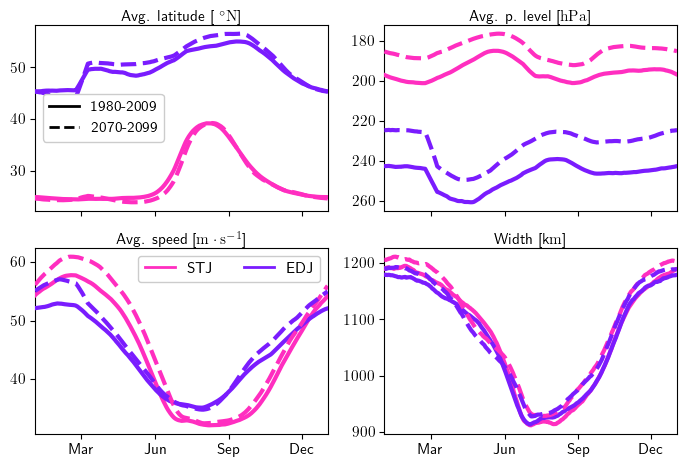

In [10]:
data_vars = ["mean_lat", "mean_lev", "mean_s", "width"]
plot_seasonal(data_vars, props_cesm, nrows=2, ncols=2, clear=False, suffix="_subset")
plt.savefig(f"{FIGURES}/jet_props_cesm/seasonal_subset.pdf")

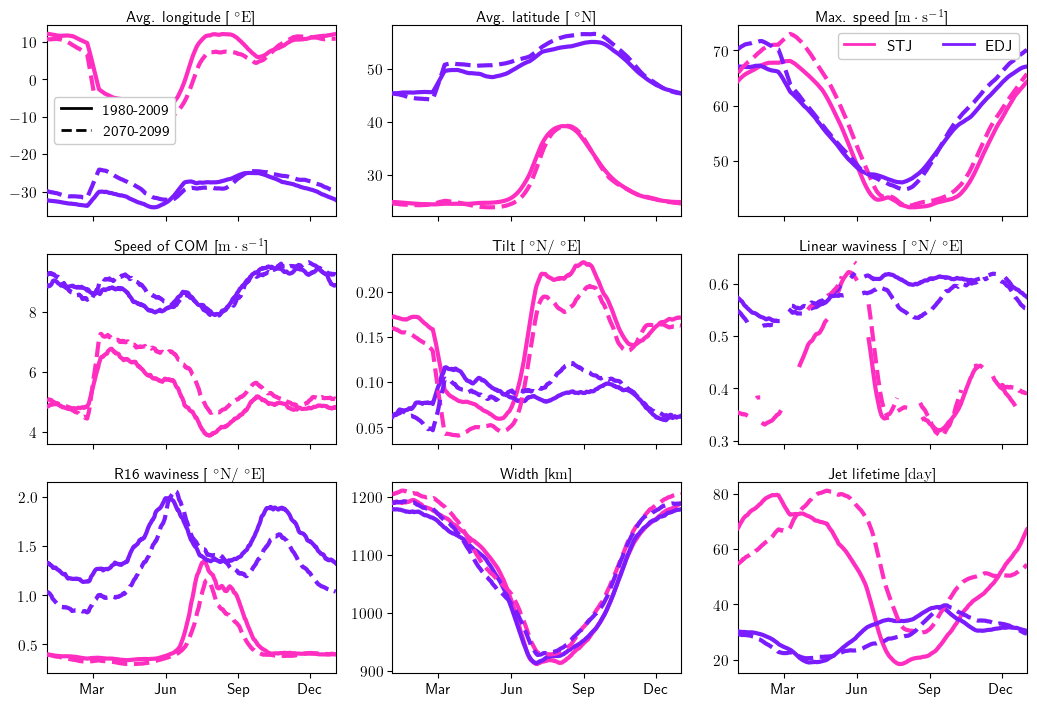

In [19]:
data_vars = ["mean_lon", "mean_lat", "s_star", "com_speed", "tilt", "waviness1", "wavinessR16", "width", "persistence"]
plot_seasonal(data_vars, props_cesm, nrows=3, ncols=3, clear=False, suffix="_subset")

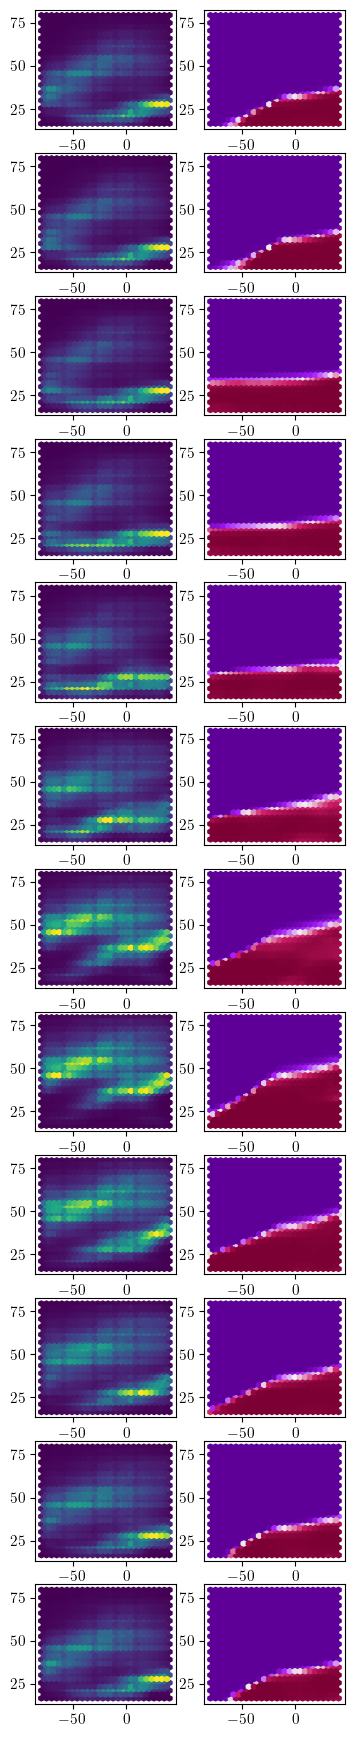

In [18]:
fig, axes = plt.subplots(12, 2, figsize=(4, 22))
for month in range(1, 13):
    jets_ = jets_cesm.filter(pl.col("time").dt.month() == month)
    axes[month - 1, 0].hexbin(jets_["lon"], jets_["lat"], gridsize=25)
    axes[month - 1, 1].hexbin(jets_["lon"], jets_["lat"], gridsize=25, C=jets_["is_polar"].cast(pl.UInt8), cmap=BLUEWHITERED)

# idk som stuff

In [ ]:
metric = "euclidean"
nx = 6
ny = 4
dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
exp_s = Experiment()
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
kwargs_som = dict(
    nx=nx,
    ny=ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05)
)
net, centers, labels = exp_s.som_cluster(**kwargs_som)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [24]:
unique_labels = np.arange(24)[None, :]
years_per_group = 10
labels_gb = labels.resample(time=f"{years_per_group}YS")
nyears = len(labels_gb)
fig, axes = plt.subplots(2, 3, subplot_kw={"aspect": "equal"}, figsize=(6, 4))
axes = axes.flatten()
pops = []
for (year, theselabels), ax in zip(labels_gb, axes):
    year_int = year.astype('datetime64[Y]').astype(int) + 1970
    pop_thisyear = (theselabels.values.flatten()[:, None] == unique_labels).sum(axis=0)
    pops.append(pop_thisyear)
    net.plot_on_map(
        pop_thisyear,
        fig=fig, 
        ax=ax,
    )
    ax.set_title(str(year_int))

In [ ]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    timestepwise.append((unique, count))
    group = [] 

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 2200, 200), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[i]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
# plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

# Future som stuff

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler(da_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_s_cesm = Experiment(dh)

In [8]:
X, da_weighted = exp_s_cesm.prepare_for_clustering()
X = _compute(X[:10000])
X, Xmin, Xmax = to_zero_one(X)

In [20]:
df_data = pl.DataFrame(X)

In [22]:
df_data

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_6656,column_6657,column_6658,column_6659,column_6660,column_6661,column_6662,column_6663,column_6664,column_6665,column_6666,column_6667,column_6668,column_6669,column_6670,column_6671,column_6672,column_6673,column_6674,column_6675,column_6676,column_6677,column_6678,column_6679,column_6680,column_6681,column_6682,column_6683,column_6684,column_6685,column_6686,column_6687,column_6688,column_6689,column_6690,column_6691,column_6692
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.343827,0.372699,0.399857,0.429091,0.451892,0.466842,0.495314,0.492682,0.494935,0.497165,0.496016,0.512509,0.507444,0.484021,0.464548,0.45609,0.426772,0.416683,0.385518,0.364999,0.368374,0.379135,0.387037,0.416766,0.450602,0.489468,0.507384,0.500717,0.472338,0.427634,0.372641,0.398064,0.452594,0.507285,0.540113,0.549923,0.523947,…,0.252192,0.25901,0.25059,0.244916,0.241908,0.240805,0.244147,0.243211,0.246069,0.249538,0.253235,0.2566,0.26266,0.261976,0.264789,0.271075,0.280275,0.282878,0.287165,0.29445,0.299299,0.302844,0.308157,0.303517,0.299733,0.294717,0.289364,0.287239,0.290976,0.28936,0.288359,0.29243,0.292952,0.289579,0.284849,0.28049,0.286075
0.296155,0.323094,0.350328,0.383933,0.417208,0.447891,0.487978,0.486651,0.490998,0.50834,0.515248,0.523315,0.504303,0.471477,0.449945,0.442875,0.414637,0.402466,0.371118,0.359178,0.36029,0.353368,0.331133,0.334726,0.350273,0.364489,0.366909,0.369994,0.357962,0.324385,0.268929,0.219568,0.207145,0.307073,0.406328,0.440526,0.420451,…,0.277666,0.274105,0.253608,0.235529,0.219737,0.205507,0.197472,0.185332,0.182968,0.18452,0.18641,0.188169,0.193199,0.191202,0.193346,0.199535,0.209064,0.211375,0.215479,0.222778,0.227521,0.230951,0.236119,0.232987,0.230931,0.2275,0.223813,0.223846,0.230483,0.231536,0.233471,0.241,0.244964,0.245821,0.247318,0.266873,0.284388
0.358323,0.380859,0.39948,0.423023,0.456607,0.49025,0.525442,0.504486,0.483525,0.473455,0.471896,0.480785,0.472924,0.456075,0.452844,0.468014,0.464035,0.475293,0.458968,0.444171,0.434514,0.413791,0.365513,0.329637,0.309614,0.292632,0.271885,0.246817,0.232979,0.204609,0.172017,0.140835,0.119329,0.155984,0.241579,0.310036,0.345465,…,0.315863,0.328423,0.320599,0.314265,0.30948,0.305718,0.305498,0.300999,0.299832,0.299221,0.298923,0.298448,0.300632,0.296411,0.295344,0.297274,0.301534,0.29872,0.296759,0.296997,0.29414,0.289516,0.286395,0.273877,0.262638,0.250394,0.238044,0.229366,0.227259,0.219515,0.212585,0.211399,0.206696,0.199844,0.191518,0.183524,0.174136
0.359746,0.398745,0.423739,0.430206,0.420219,0.408283,0.415571,0.393044,0.378436,0.38184,0.378361,0.385029,0.380025,0.370675,0.375153,0.395554,0.394287,0.410338,0.403529,0.406517,0.428559,0.453286,0.4517,0.457148,0.456958,0.444976,0.40549,0.35123,0.297464,0.258262,0.240281,0.237827,0.254277,0.281395,0.294506,0.298443,0.295106,…,0.350837,0.355591,0.340243,0.328217,0.319022,0.311572,0.307816,0.301955,0.298101,0.29283,0.285543,0.275604,0.266051,0.247606,0.23066,0.218647,0.215603,0.208726,0.203279,0.200804,0.195552,0.188813,0.183576,0.171138,0.159947,0.14699,0.133364,0.123498,0.120843,0.111681,0.10351,0.102147,0.097656,0.093696,0.088661,0.084573,0.081624
0.413679,0.425203,0.423847,0.4225,0.422507,0.426502,0.445107,0.426482,0.415816,0.424772,0.430546,0.446796,0.444311,0.428034,0.416588,0.417058,0.397786,0.399339,0.382535,0.379722,0.400358,0.421064,0.415811,0.419877,0.423912,0.426564,0.435488,0.443664,0.44596

In [21]:
weights = np.random.rand(8 * 6, X.shape[1])
weights_df = pl.DataFrame(weights)

SyntaxError: incomplete input (4250954051.py, line 2)

In [17]:
df = pl.concat([df_data, weights_df], how="horizontal")

In [19]:
for i in trange(X.shape[0]):
    for j in trange(weights.shape[0], leave=False):
        a = df[f"sample{i}"]
        b = df[f"weight{j}"]

  0%|          | 0/48 [00:00<?, ?it/s]

 12%|█▏        | 1164/10000 [00:06<00:49, 176.86it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)
 18%|█▊        | 1796/10000 [00:09<00:47, 173.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)
 19%|█▉        | 1947/10000 [00:10<00:44, 182.91it/s]


KeyboardInterrupt: 

In [12]:
df.select([(pl.col(f"weight{i}") - pl.col(f"sample{j}")).pow(2).sum().alias("ij") for j in range(weights.shape[0]) for i in range(X.shape[0])])

KeyboardInterrupt: 

In [20]:
from sklearn.metrics import pairwise_distances
with Timer():
    pairwise_distances(X, weights)

Elapsed time: 4.5562 seconds


In [8]:
kwargs_som_2 = dict(
    nx=8,
    ny=6,
    metric="euclidean",
    return_type=RAW_REALSPACE,
    force=False,
)
exp_s_cesm.da = _compute(exp_s_cesm.da)
exp_s_cesm.som_cluster(**kwargs_som_2)

Random weights init


100%|██████████| 50/50 [49:50<00:00, 59.81s/it]   


[########################################] | 100.00% Completed | 7.11 ss


  0%|          | 0/48 [00:00<?, ?it/s]

IndexError: Boolean array size 270480 is used to index array with shape (49, 5520, 69, 97).